In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

import matplotlib 


import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorboard as tb
import os
from tensorboard.backend.event_processing import event_accumulator

In [3]:
def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def tensorboard_reader(directory, tag='AgeDelta/epoch'):
    """
    Sources: 
    https://stackoverflow.com/questions/41074688/how-do-you-read-tensorboard-files-programmatically
    https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
    """
    
    for dataset in ['train', 'validation']:
    
        dct = {}
        steps = []
        values = []
    
        if dataset == 'train':
            dir_name = directory + '/train/'
        else:
            dir_name = directory + '/validation/'

        list_of_files = os.listdir(dir_name)

        for file in list_of_files:
            file_name=dir_name+file
#             print(file_name)
            ea = event_accumulator.EventAccumulator(file_name,
              size_guidance={
              event_accumulator.COMPRESSED_HISTOGRAMS: 500,
              event_accumulator.IMAGES: 4,
              event_accumulator.AUDIO: 4,
              event_accumulator.SCALARS: 0,
              event_accumulator.HISTOGRAMS: 1,
          })
            ea.Reload()
#             print(ea.Tags())
            if tag in ea.Tags()['scalars']:
                for e in ea.Scalars(tag):
                    step = e.step
                    value = e.value
                    steps.append(step)
                    values.append(value)

        dct['step'] = steps
        
        if dataset == 'train':
            dct['train'] = values
            dfp = pd.DataFrame.from_dict(dct)
        else:
            dct['validation'] = values
            dfv = pd.DataFrame.from_dict(dct)

    df = pd.merge(dfp, dfv, how='left', on='step')
    df = df.sort_values('step')
    
    return df

def linear_plotter(x, y_train, y_validation, y_MSE, xlabel, ylabel, title, ylim_flag=False, xlim=None):
    
    if isinstance(x, np.ndarray):
        pass
    else:
        x = x.values
        y_train = y_train.values
        y_validation = y_validation.values
        y_MSE = y_MSE.values
        
        
    x = np.delete(x, np.argwhere(np.isnan(y_validation)))
    y_MSE = np.delete(y_MSE, np.argwhere(np.isnan(y_validation)))
    y_train = np.delete(y_train, np.argwhere(np.isnan(y_validation)))
    y_validation = np.delete(y_validation, np.argwhere(np.isnan(y_validation)))
    
    x = np.delete(x, np.argwhere(np.isnan(y_MSE)))
    y_train = np.delete(y_train, np.argwhere(np.isnan(y_MSE)))
    y_validation = np.delete(y_validation, np.argwhere(np.isnan(y_MSE)))
    y_MSE = np.delete(y_MSE, np.argwhere(np.isnan(y_MSE)))
    
    plt.figure(figsize=[14.4,7.2])
    plt.plot(x, y_train, label='Train')
    plt.plot(x, y_validation, label='Validation')
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        ylim_max = np.max(y_train) + 5
        plt.ylim((ylim_min, ylim_max))
    
    best_validation_MSE = np.min(y_MSE)
    
    best_validation = y_validation[np.where(y_MSE == best_validation_MSE)[0][0]]
    best_epoch = x[np.where(y_MSE == best_validation_MSE)[0][0]]
    best_train = y_train[np.where(y_MSE == best_validation_MSE)[0][0]]
    
#     best_validation = np.min(y_validation)
#     best_epoch = x[np.where(y_validation == np.min(y_validation))[0][0]]
#     best_train = y_train[np.where(y_validation == np.min(y_validation))[0][0]]
    
    
    gap = best_train - best_validation
    print(best_epoch, best_validation)
    print(-gap)
    plt.scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red', label='Selected Best Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
def linear_plotter_comparison(Xs, Ys, Labels,
                              xlabel, ylabel, title, ylim_flag=False):
    
    plt.figure(figsize=[7,5], facecolor='white')
    for idx, x in enumerate(Xs):
        plt.plot(x, Ys[idx], label=Labels[idx])
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        y_max = [np.max(Ys[idx]) for idx in range(len(Ys))]
        ylim_max = min(y_max)
        plt.ylim((ylim_min, ylim_max))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_everything(network='49', ylim2=[2.175, 2.45], control=False, preambul = 'SM', range_points = [1,2,3,4,5,6,7,8,9]):
    dfs = []
    names = []
    if control == True:
        preambul = 'AM'
        range_points = [10,11,12]

    tag = 'AgeDelta/epoch'
    for i in range_points:
        name = preambul + str(int(i)) + '-' + network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name)

    
    dfsMSE = []
    namesMSE = []
    tagMSE = 'loss/epoch'
    for i in range_points:
        nameMSE = preambul + str(int(i)) + '-' + network
        directoryMSE = '../logs/' + nameMSE
        dfMSE = tensorboard_reader(directory=directoryMSE, tag=tagMSE)
        dfsMSE.append(dfMSE)
        namesMSE.append(nameMSE)

        
    dfs2 = []
    names2 = []

    tag2 = 'LearningRate/iteration'
    for i in range_points:
        name2 = preambul + str(int(i)) + '-' + network
        directory2 = '../logs/' + name
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2)

    for i, df in enumerate(dfs):
        name = names[i]
        df = df.dropna(axis=0)
        linear_plotter(x=df.step, y_train=df.train, y_validation=df.validation,
                       y_MSE = dfsMSE[i].validation,
                       xlabel='Epochs', ylabel=tag, title=name, xlim=[-2, 300])

    Xs = [dfs[i].step.values for i in range(len(dfs))]
    Ys = [dfs[i].validation.values for i in range(len(dfs))]
    YsMSE = [dfsMSE[i].validation.values for i in range(len(dfsMSE))]
    Labels = [preambul + str(int(i)) + '-' + network for i in range_points]
    xlabel='Epochs'
    ylabel='AgeDelta/epoch'
    
#     print(YsMSE)

    plt.figure(figsize=[14.4,7.2], facecolor='white')
    for idx, x in enumerate(Xs):
        y = Ys[idx]
        yMSE = YsMSE[idx]
        x = np.delete(x, np.argwhere(np.isnan(y)))
        yMSE = np.delete(yMSE, np.argwhere(np.isnan(y)))
        y = np.delete(y, np.argwhere(np.isnan(y)))
        
        plt.plot(x, y, label=Labels[idx], alpha=0.3)
        best_validation_MSE = np.min(yMSE)
#         best_validation = np.min(y)
        best_validation = y[np.where(yMSE == best_validation_MSE)[0][0]]
#         best_epoch = x[np.where(y == np.min(y))[0][0]]
        best_epoch = x[np.where(yMSE == best_validation_MSE)[0][0]]

        label = 'Selected Best Epoch for ' + Labels[idx]
        if idx < 3:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='*', label=label)
        else:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.ylim(ylim2)
    plt.xlim([-1,300])
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

In [18]:
net58 = "58"
net74 = "74"
net63 = "63"
net68 = "68"

net59 = "59"
net75 = "75"
net64 = '64'
net69 = "69"

net60 = "60"
net76 = "76"
net65 = '65'
net70 = "70"

net61 = "61"
net77 = "77"
net66 = '66'
net71 = "71"

net62 = "62"
net78 = '78'
net67 = "67"
net72 = "72"

net73 = "73"







dfs = [
    net58,
    net74,
    net63,
    net68,
    
    net59,
    net75,
    net64,
    net69,
    
    net60,
    net76,
    net65,
    net70,
    
    net61,
    net77,
    net66,
    net71,
    
    net62,
    net78,
    net67,
    net72,
    net73,
]

names = [
    'p2_FA',           # 58
    'p2_FA_stepLR',           # 74
    'p5_FA',           # 63
    'p5_FA_noFinalLayer',           # 68
    
    'p2_TBSS_FA',      # 59
    'p2_TBSS_FA_stepLR',      # 75
    'p5_TBSS_FA',      # 64
    'p5_TBSS_FA_noFinalLayer',      # 69
    
    'p2_rsfmri_0',     # 60
    'p2_rsfmri_0_stepLR',     # 76
    'p5_rsfmri_0',     # 65
    'p5_rsfmri_0_noFinalLayer',     # 70
        
    'p2_SummedTracts',  # 61
    'p2_SummedTracts_stepLR',  # 77
    'p5_SummedTracts',  # 66
    'p5_SummedTracts_noFinalLayer',  # 71
    
    'p2_T2_Lession',  # 62
    'p2_T2_Lession_stepLR',  # 78
    'p5_T2_Lession',  # 67 
    'p5_T2_Lession_noFinalLayer',  # 72
    'p5_T1_stepLR', #73

]

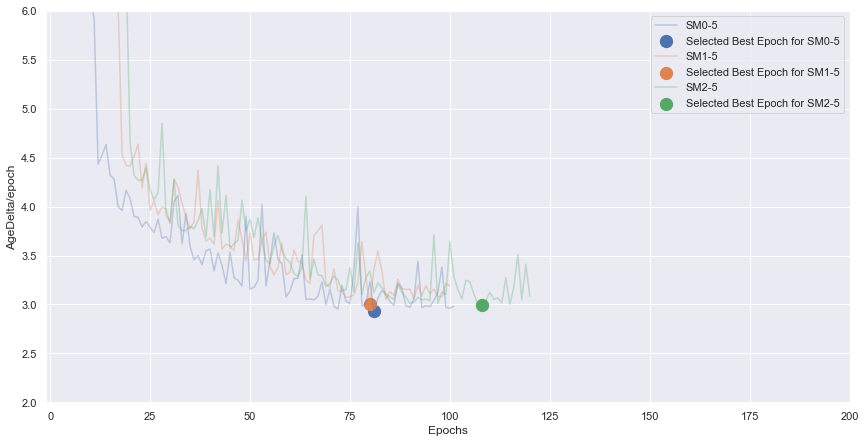

In [17]:
def plot_everything_vs_baseline(network='49', ylim2=[2.175, 2.45], 
                               control=False, preambul = 'SM', 
                               range_points = [1,2,3,4,5,6,7,8,9],
                               baseline_network='1',
                               baseline_preambul = 'SM',
                               baseline_range_points = [0,1]):
    dfs = []
    names = []

    tag = 'AgeDelta/epoch'
    for i in baseline_range_points:
        name = baseline_preambul + str(int(i)) + '-' + baseline_network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name+'_bsl')
    for i in range_points:
        name = preambul + str(int(i)) + '-' + network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name)

    
    dfsMSE = []
    namesMSE = []
    tagMSE = 'loss/epoch'
    for i in baseline_range_points:
        nameMSE = baseline_preambul + str(int(i)) + '-' + baseline_network
        directoryMSE = '../logs/' + nameMSE
        dfMSE = tensorboard_reader(directory=directoryMSE, tag=tagMSE)
        dfsMSE.append(dfMSE)
        namesMSE.append(nameMSE+'_bsl')
    for i in range_points:
        nameMSE = preambul + str(int(i)) + '-' + network
        directoryMSE = '../logs/' + nameMSE
        dfMSE = tensorboard_reader(directory=directoryMSE, tag=tagMSE)
        dfsMSE.append(dfMSE)
        namesMSE.append(nameMSE)

        
    dfs2 = []
    names2 = []

    tag2 = 'LearningRate/iteration'
    for i in baseline_range_points:
        name2 = baseline_preambul + str(int(i)) + '-' + baseline_network
        directory2 = '../logs/' + name
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2+'_bsl')
    for i in range_points:
        name2 = preambul + str(int(i)) + '-' + network
        directory2 = '../logs/' + name
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2)

    # for i, df in enumerate(dfs):
    #     name = names[i]
    #     df = df.dropna(axis=0)
    #     linear_plotter(x=df.step, y_train=df.train, y_validation=df.validation,
    #                    y_MSE = dfsMSE[i].validation,
    #                    xlabel='Epochs', ylabel=tag, title=name, xlim=[-2, 150])

    Xs = [dfs[i].step.values for i in range(len(dfs))]
    Ys = [dfs[i].validation.values for i in range(len(dfs))]
    YsMSE = [dfsMSE[i].validation.values for i in range(len(dfsMSE))]
    Labels = [baseline_preambul + str(int(i)) + '-' + baseline_network for i in baseline_range_points]
    Labels = Labels +[preambul + str(int(i)) + '-' + network for i in range_points]
    xlabel='Epochs'
    ylabel='AgeDelta/epoch'
    

    plt.figure(figsize=[14.4,7.2], facecolor='white')
    for idx, x in enumerate(Xs):
        y = Ys[idx]
        yMSE = YsMSE[idx]
        x = np.delete(x, np.argwhere(np.isnan(y)))
        yMSE = np.delete(yMSE, np.argwhere(np.isnan(y)))
        y = np.delete(y, np.argwhere(np.isnan(y)))
        
        plt.plot(x, y, label=Labels[idx], alpha=0.3)
        # plt.plot(x, y, alpha=0.3)
        best_validation_MSE = np.min(yMSE)
        best_validation = y[np.where(yMSE == best_validation_MSE)[0][0]]
        best_epoch = x[np.where(yMSE == best_validation_MSE)[0][0]]

        label = 'Selected Best Epoch for ' + Labels[idx]
        if idx < len(baseline_range_points):
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='*', label=label)
        else:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.ylim(ylim2)
    plt.xlim([-1,200])


plot_everything_vs_baseline(network='5', range_points=[0,1,2], baseline_network='3', 
                            baseline_range_points=[],
                            ylim2=[2,6])

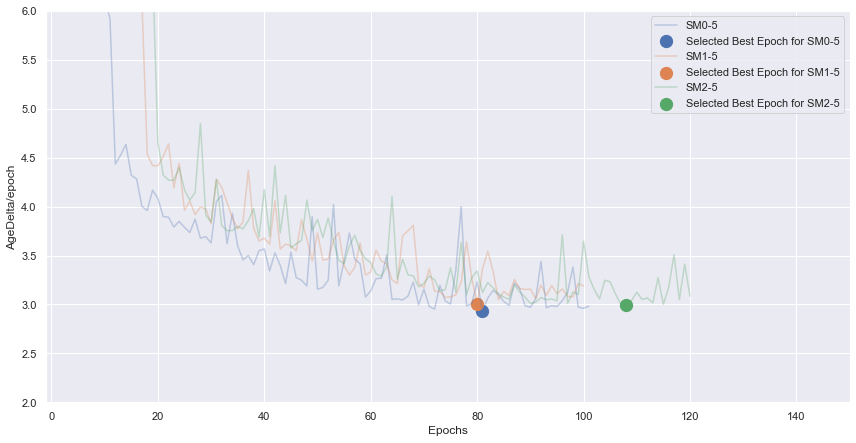

In [16]:
plot_everything_vs_baseline(network='5', range_points=[0,1,2], baseline_network='3', 
                            baseline_range_points=[],
                            ylim2=[2,6])

/var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/ipykernel_7933/3917672174.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[14.4,7.2], facecolor='white')


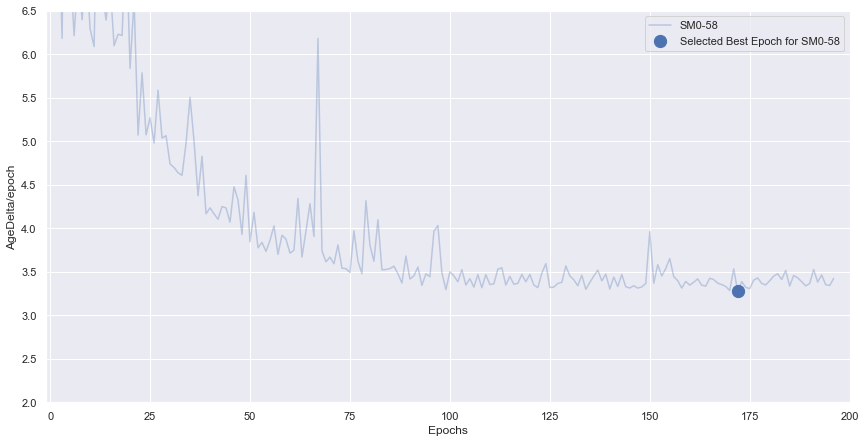

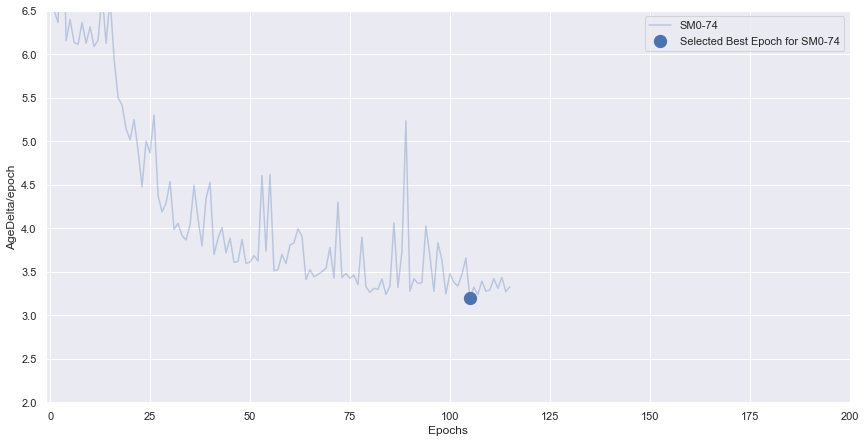

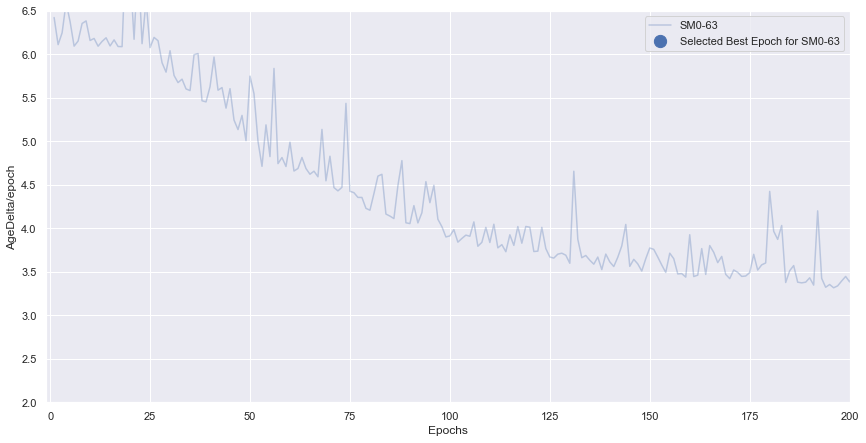

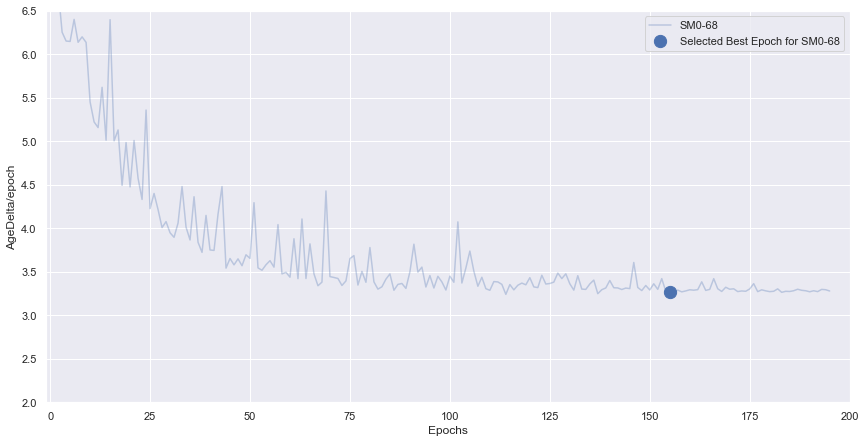

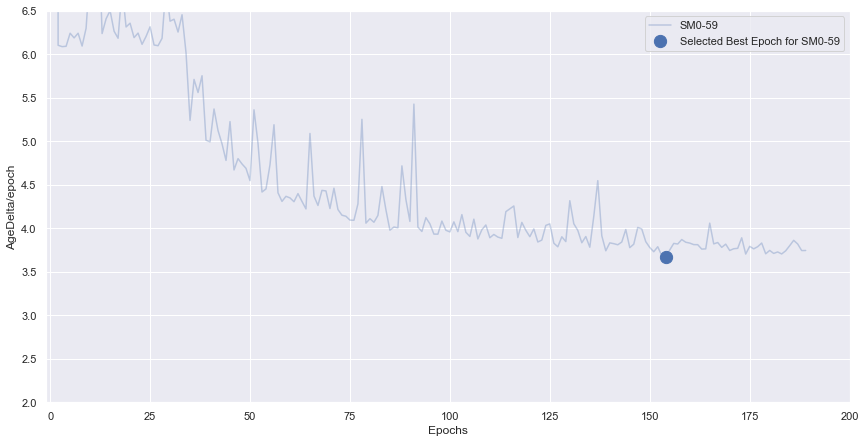

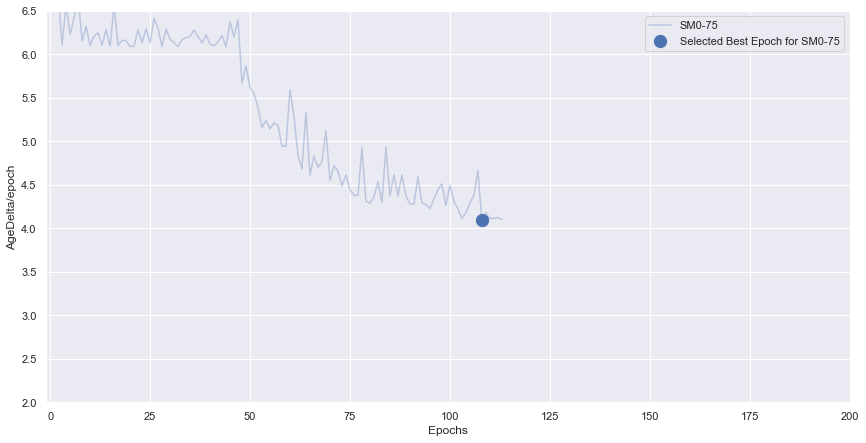

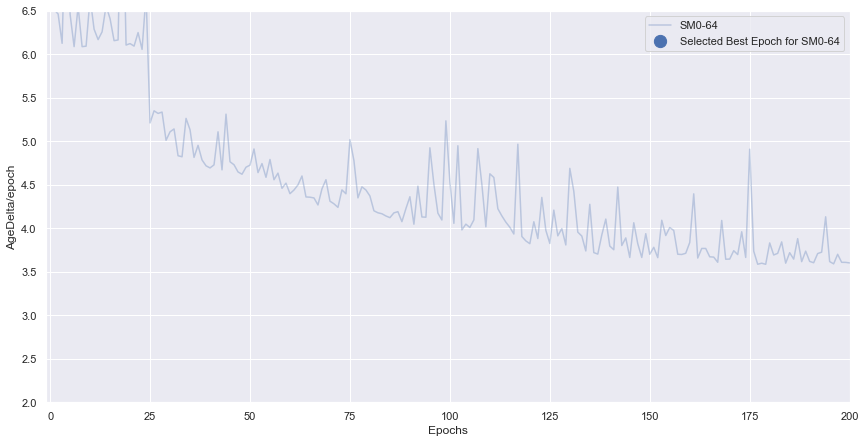

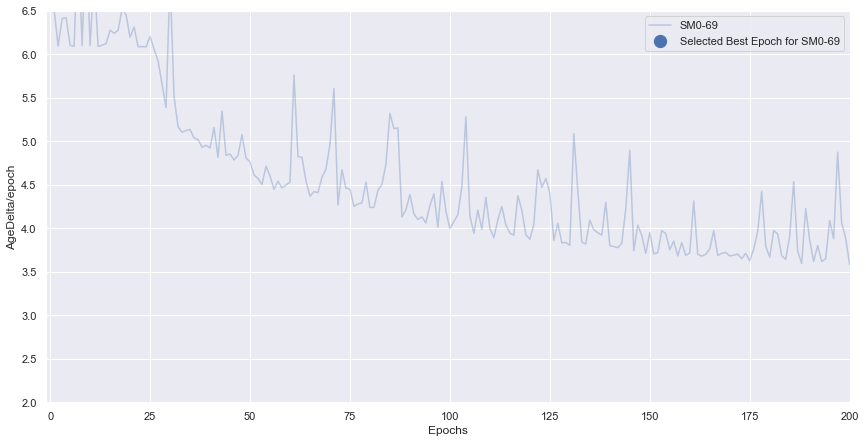

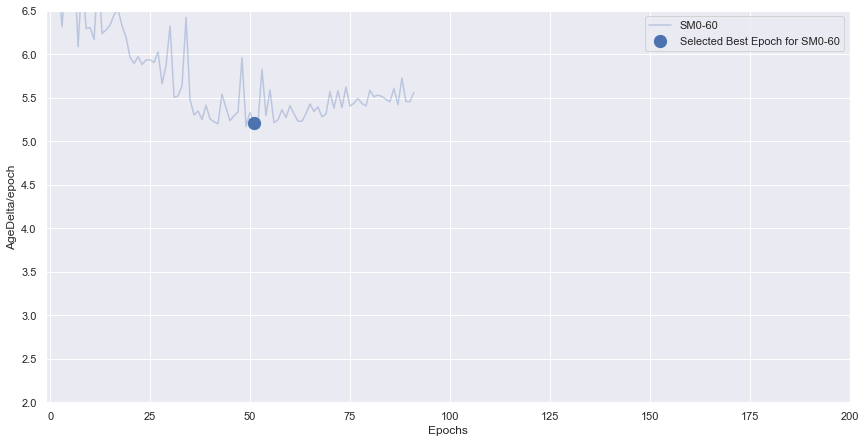

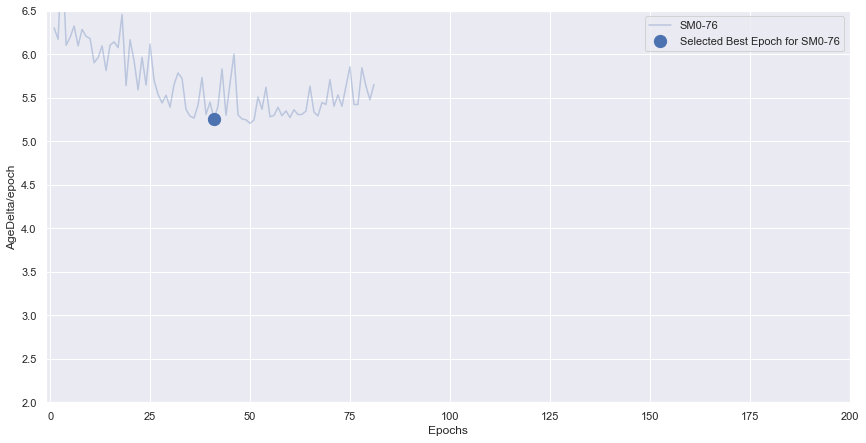

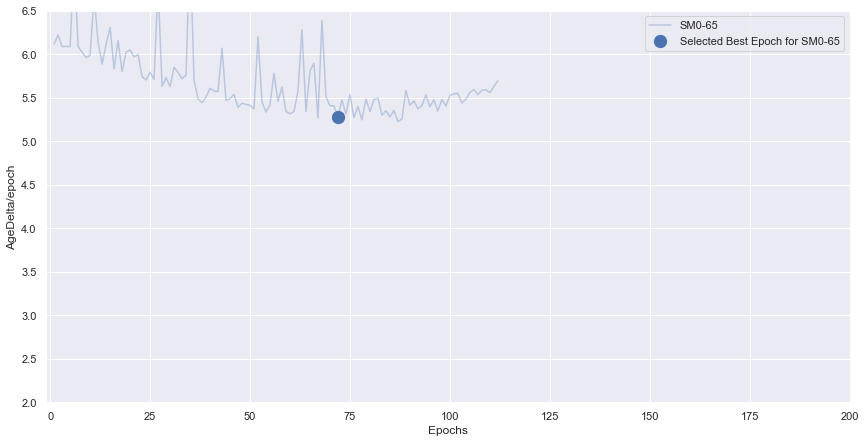

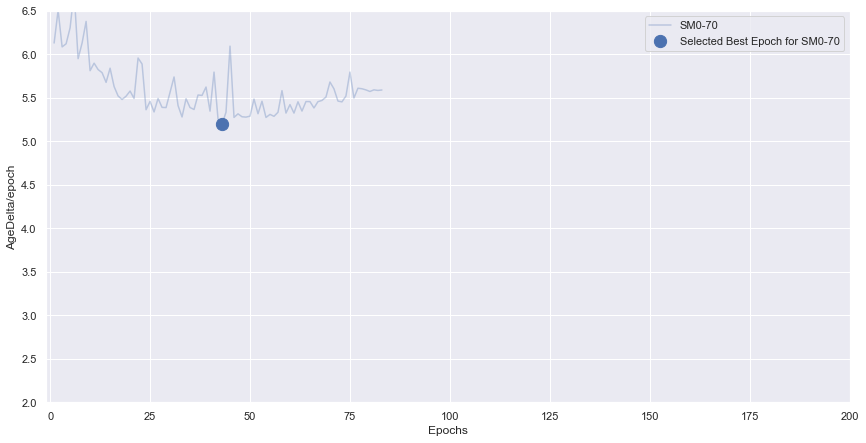

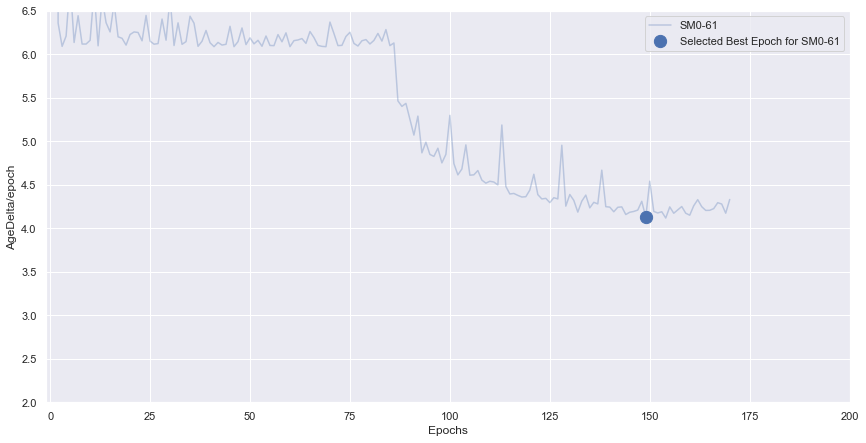

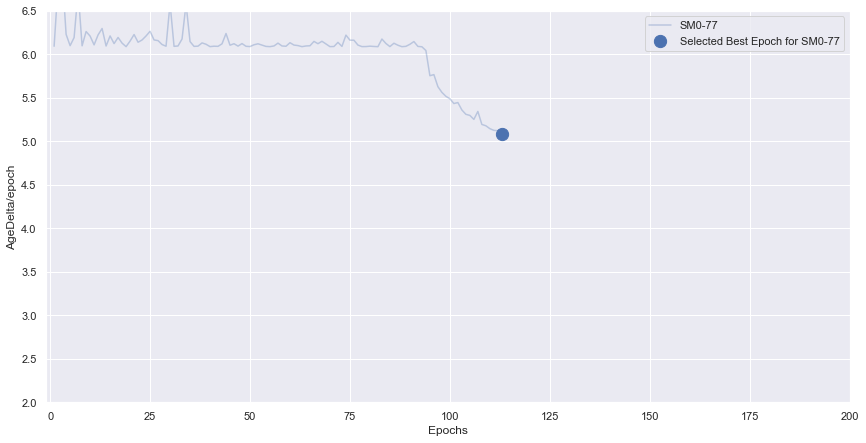

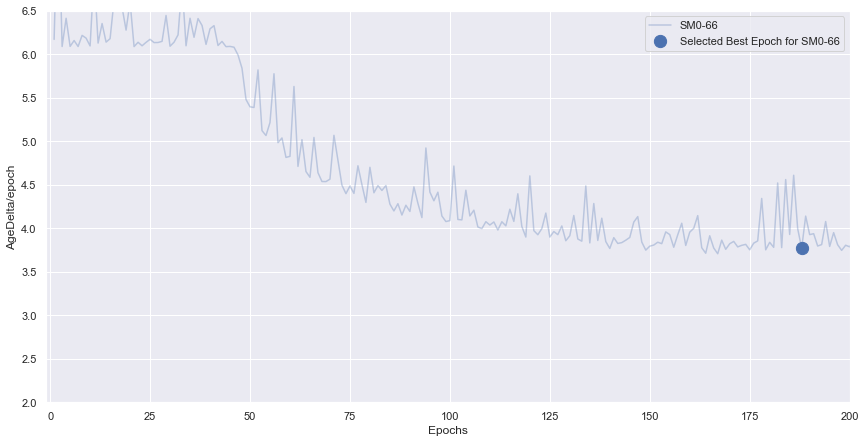

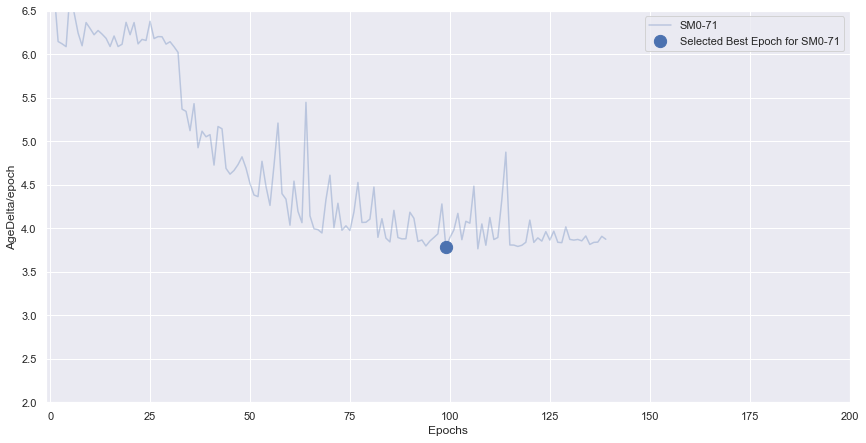

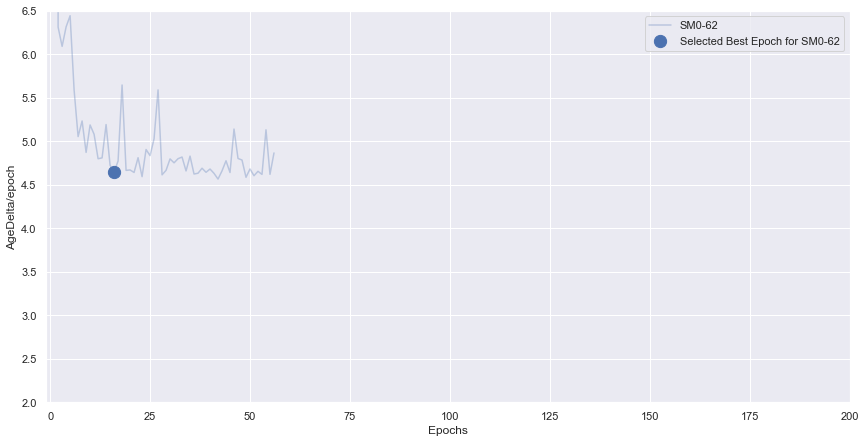

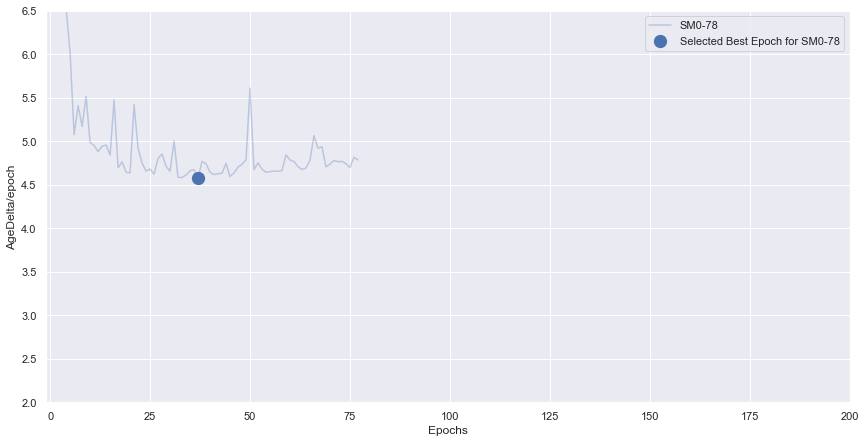

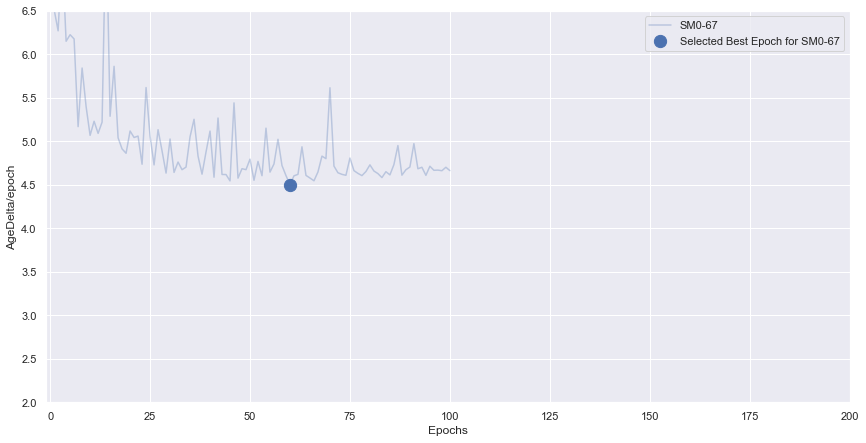

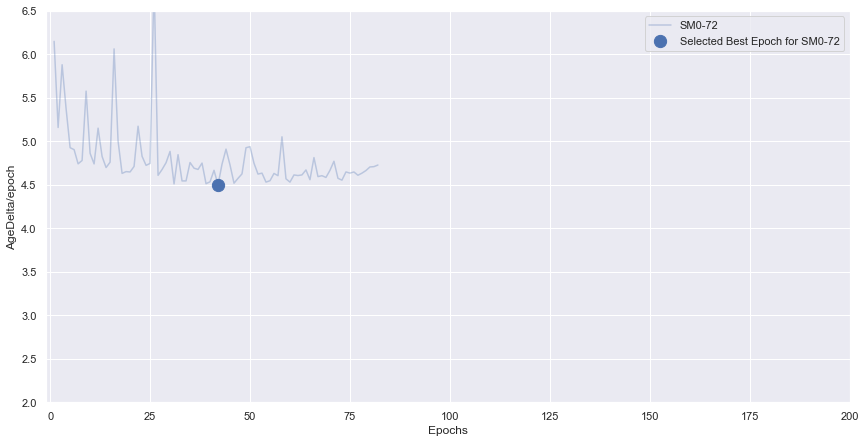

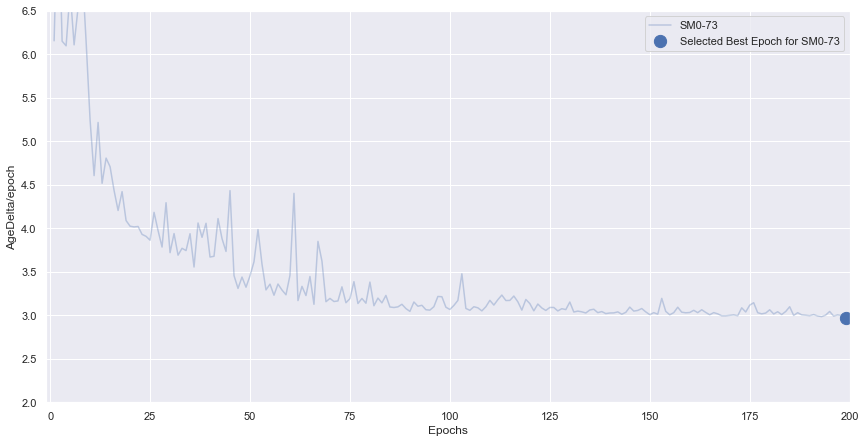

In [20]:
for df in dfs:
    # plot_everything(network=df, ylim2=[2, 4])
    plot_everything_vs_baseline(network=df, range_points=[0], baseline_network='3', 
                                baseline_range_points=[],
                            ylim2=[2,6.5])
    

In [ ]:
plot_everything(network='3', ylim2=[2, 4])

In [7]:
ldfs = len(dfs)

In [8]:
ldfs

32

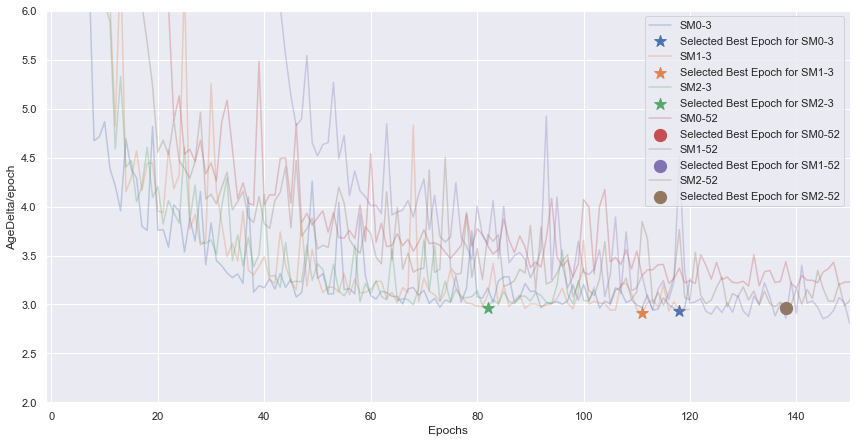

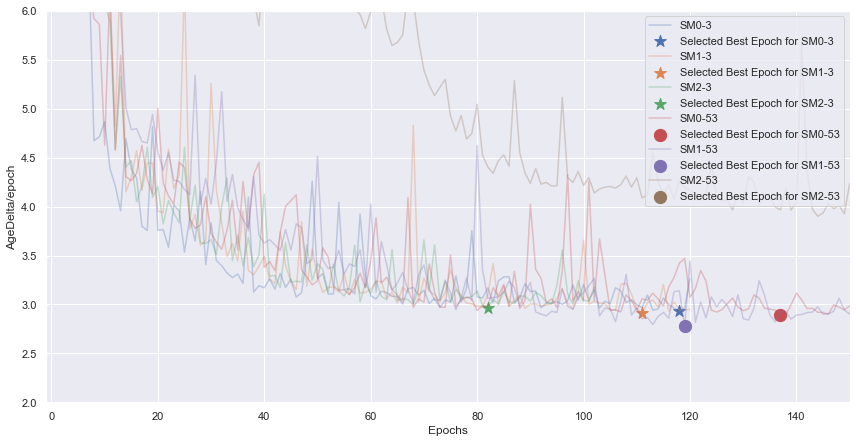

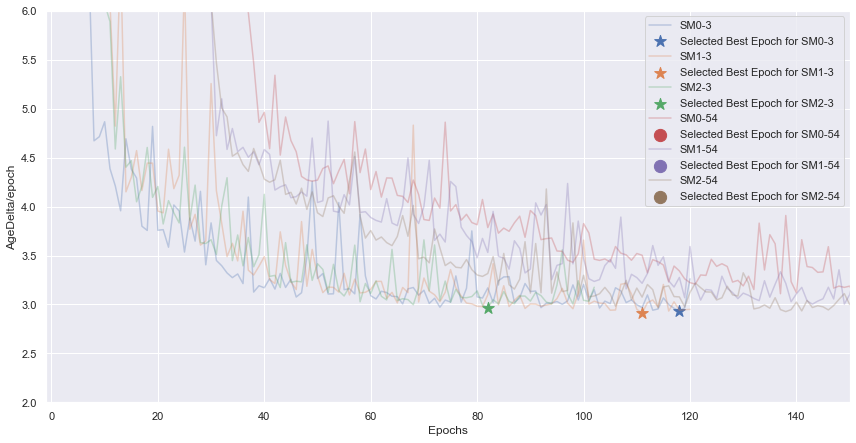

In [12]:
for idx in range(ldfs-3,ldfs):
    plot_everything_vs_baseline(network=dfs[idx], range_points=[0,1,2], baseline_network='3', 
                                baseline_range_points=[0,1,2],
                            ylim2=[2,6])

list